### LSTM

In [1]:
import pandas as pd
import numpy as np
data = pd.read_csv('../data/BTC-I.csv', parse_dates=['Date'], index_col=['Date'])
data

Close           High            Low           Open  \
Date                                                                     
2014-11-05     339.485992     343.368988     330.683014     330.683014   
2014-11-06     349.290009     352.966003     338.424011     339.458008   
2014-11-07     342.415009     352.731995     341.776001     349.817993   
2014-11-08     345.488007     347.032013     342.153992     342.153992   
2014-11-09     363.264008     363.626007     344.255005     345.376007   
...                   ...            ...            ...            ...   
2025-08-17  117453.062500  118595.773438  117279.523438  117492.789062   
2025-08-18  116252.312500  117614.171875  114723.679688  117453.906250   
2025-08-19  112831.179688  116764.500000  112730.398438  116241.859375   
2025-08-20  114274.742188  114625.796875  112387.960938  112828.023438   
2025-08-21  112483.562500  114691.304688  112221.921875  114269.484375   

                 Volume          ema20          ema50      rsi10      rsi30  \
Date                                                                          
2014-11-05     19817200     349.705580     374.193837  42.949789  40.281067   
2014-11-06     18797000     349.666002     373.217216  50.355032  42.954417   
2014-11-07     16834200     348.975431     372.009287  45.730051  41.603388   
2014-11-08      8535470     348.643295     370.969237  48.097614  42.440506   
2014-11-09     24205600     350.035744     370.667071  59.463792  46.987959   
...                 ...            ...            ...        ...        ...   
2025-08-17  45852169525  117529.131310  115032.614311  49.456598  54.355996   
2025-08-18  72787808090  117407.529518  115080.445612  45.102138  52.687407   
2025-08-19  71657600353  116971.686677  114992.239105  35.271018  48.315885   
2025-08-20  67993811526  116714.834821  114964.101971  41.272651  50.122314   
2025-08-21  59795001344  116311.856505  114866.825914  36.594755  47.970214   

                  macd      signal        hist  Price-Up  
Date                                                      
2014-11-05  -13.723550  -12.462599   -1.260951         1  
2014-11-06  -12.079876  -12.386054    0.306178         0  
2014-11-07  -11.202868  -12.149417    0.946549         1  
2014-11-08  -10.142946  -11.748123    1.605177         1  
2014-11-09   -7.778906  -10.954279    3.175374         1  
...                ...         ...         ...       ...  
2025-08-17  830.685839  916.008073  -85.322234         0  
2025-08-18  632.601985  859.326856 -226.724870         0  
2025-08-19  197.288064  726.919097 -529.631033         1  
2025-08-20  -30.862166  575.362845 -606.225011         0  
2025-08-21 -352.146770  389.860922 -742.007691         0  

[3943 rows x 13 columns]

In [3]:
features = ['Close', 'High', 'Low', 'Open', 'Volume', 'ema20', 'ema50', 'rsi10', 'rsi30', 'macd', 'signal', 'hist']
target = ['Price-Up']
# Separar X e y
X = data[features]
y = data[target].to_numpy()
X.shape, y.shape


((3943, 12), (3943, 1))

#### Dividimos el dataset

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, shuffle=False)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3548, 12), (395, 12), (3548, 1), (395, 1))

### Escalamos

In [5]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled.shape, X_test_scaled.shape

((3548, 12), (395, 12))

#### Creamos las secuencias

In [6]:
sequence_length = 30 
X_train_sequences = []
y_train_sequences = []
X_test_sequences = []
y_test_sequences = []
for i in range(sequence_length, len(X_train)): 
    X_train_sequences.append(X_train_scaled[i - sequence_length: i])
    y_train_sequences.append(y_train[i])

for i in range(sequence_length, len(X_test)): 
    X_test_sequences.append(X_test_scaled[i - sequence_length: i])
    y_test_sequences.append(y_test[i])

X_train_sequences = np.array(X_train_sequences)
y_train_sequences = np.array(y_train_sequences)
X_test_sequences = np.array(X_test_sequences)
y_test_sequences = np.array(y_test_sequences)
X_train_sequences.shape, y_train_sequences.shape, X_test_sequences.shape, y_test_sequences.shape
#Aca optenemos la (cantidad de secuencias(ventanas), cantidad de dias, cantidad de features)

((3518, 30, 12), (3518, 1), (365, 30, 12), (365, 1))

### Pytorch Implementation

In [7]:
# Convertimos los datos a tensores 
import torch
X_train_tensor = torch.tensor(X_train_sequences, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_sequences, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_sequences, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_sequences, dtype=torch.float32)

X_train_tensor.shape, X_test_tensor.shape, y_train_tensor.shape, y_test_tensor.shape 

(torch.Size([3518, 30, 12]),
 torch.Size([365, 30, 12]),
 torch.Size([3518, 1]),
 torch.Size([365, 1]))

#### Arquitectura 

In [8]:
import torch
import torch.nn as nn
# Creamos la clase o sub-clase de nn.Module 
# Creamos dos metodos init y forward

class MyLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size
        # Definimos una capa LSTM y un full connected layer

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

        
    def forward(self, x):
        # Inicializamos los vectores de estado oculto y de celda con ceros 
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        out, _ = self.lstm(x, (h0, c0))
        out = out[:,-1,:] 
        out = self.fc(out) 
        return out

In [10]:
# Cada instanacia lo movemos a la gpu
import torch

# Parameters of the model 
input_size = X_train_tensor.shape[2]  # 12
hidden_size = 128
num_layers  = 4
output_size = 1 # Classification 


device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

model = MyLSTM(input_size, hidden_size, num_layers, output_size).to(device)
print(model)



Using device: cuda
MyLSTM(
  (lstm): LSTM(12, 128, num_layers=4, batch_first=True)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)


In [11]:
from torch.utils.data import TensorDataset, DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor) # Instanciamos la clase  
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 32

train_loader = DataLoader(train_dataset, batch_size, shuffle=True) # Instanciamos la clase DataLoader
test_loader = DataLoader(test_dataset, batch_size, shuffle=False)

print(len(train_loader))
for batch_X, batch_y in train_loader:
    print("Batch X shape:", batch_X.shape)
    print("Batch y shape:", batch_y.shape)
    # Solo el primer batch
    break


110
Batch X shape: torch.Size([32, 30, 12])
Batch y shape: torch.Size([32, 1])


In [16]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# Training
num_epochs = 200 
model.train()
print(f'Training on {device}')

for epoch in range(num_epochs):
    for batch_X, batch_y in train_loader:
        batch_X = batch_X.to(device) #[32, 30, 8]
        batch_y = batch_y.to(device) #[32, 1]
        # Forward pass
        outputs = model(batch_X).squeeze() # [batch_size, 1] => [batch_size] 

        loss = criterion(outputs, batch_y.squeeze())

        # Backward pass
        loss.backward()

        optimizer.step()

        optimizer.zero_grad()
    if (epoch + 1 ) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')





Training on cuda
Epoch [10/200], Loss: 0.6879
Epoch [20/200], Loss: 0.6922
Epoch [30/200], Loss: 0.6850
Epoch [40/200], Loss: 0.6373
Epoch [50/200], Loss: 0.6721
Epoch [60/200], Loss: 0.6766
Epoch [70/200], Loss: 0.6676
Epoch [80/200], Loss: 0.6582
Epoch [90/200], Loss: 0.6518
Epoch [100/200], Loss: 0.6649
Epoch [110/200], Loss: 0.6482
Epoch [120/200], Loss: 0.6584
Epoch [130/200], Loss: 0.6148
Epoch [140/200], Loss: 0.6428
Epoch [150/200], Loss: 0.6538
Epoch [160/200], Loss: 0.7390
Epoch [170/200], Loss: 0.6557
Epoch [180/200], Loss: 0.6239
Epoch [190/200], Loss: 0.7390
Epoch [200/200], Loss: 0.7030


In [17]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report, confusion_matrix
import torch
import numpy as np

model.eval()  # Modo de evaluación

y_true = []  # Etiquetas reales
y_pred = []  # Predicciones binarias
y_probs = []  # Probabilidades predichas

with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X = batch_X.to(device)
        batch_y = batch_y.to(device)
        # Forward pass
        outputs = model(batch_X).squeeze()   # Logits
        probs = torch.sigmoid(outputs)       # Probabilidades
        predicted = torch.round(probs)       # Predicciones binarias (0 o 1)

        # Guardar los valores reales y predichos
        y_true.extend(batch_y.view(-1).cpu().numpy())  # Solución aquí ✅
        y_pred.extend(predicted.view(-1).cpu().numpy())
        y_probs.extend(probs.view(-1).cpu().numpy())

# Convertir listas a numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_probs = np.array(y_probs)

# Calcular métricas
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
roc_auc = roc_auc_score(y_true, y_probs)
report = classification_report(y_true, y_pred)
conf_matrix = confusion_matrix(y_true, y_pred)

# Mostrar resultados
print(f'Accuracy: {accuracy:.2f}%')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1-Score: {f1:.2f}')
print(f'ROC-AUC: {roc_auc:.2f}')
print(report)
print(conf_matrix)



Accuracy: 0.49%
Precision: 0.50
Recall: 0.35
F1-Score: 0.41
ROC-AUC: 0.51
              precision    recall  f1-score   support

         0.0       0.48      0.63      0.55       177
         1.0       0.50      0.35      0.41       188

    accuracy                           0.49       365
   macro avg       0.49      0.49      0.48       365
weighted avg       0.49      0.49      0.48       365

[[112  65]
 [122  66]]


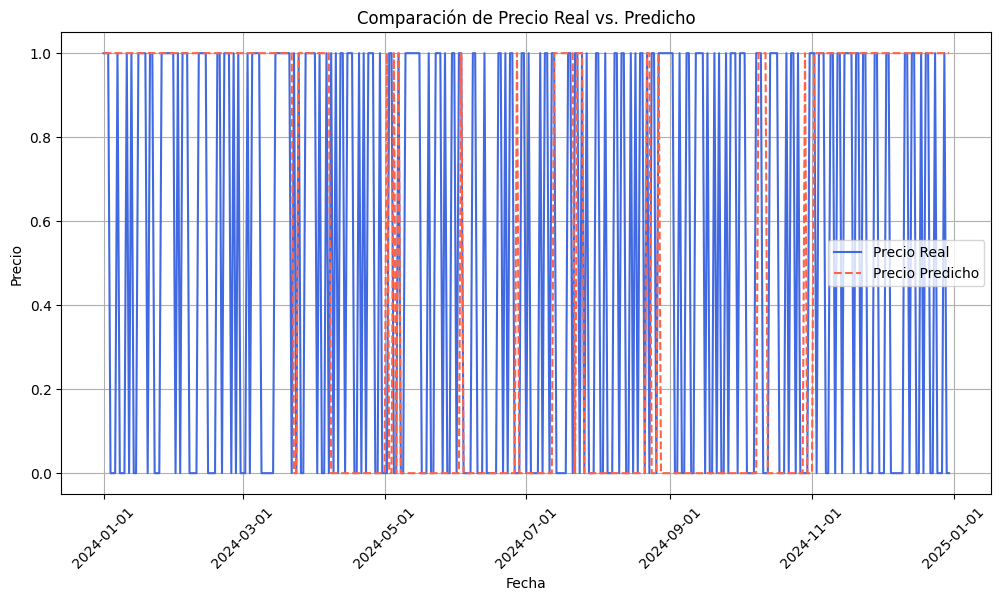

In [15]:
import matplotlib.dates as mdates 
import matplotlib.pyplot as plt
import pandas as pd

# Suponiendo que tienes un DataFrame con fechas
fechas = pd.date_range(start="2024-01-01", periods=len(y_true), freq="D")

plt.figure(figsize=(12, 6))
plt.plot(fechas, y_true, label="Precio Real", color='royalblue')
plt.plot(fechas, y_pred, label="Precio Predicho", color='tomato', linestyle='dashed')

# Mejorar formato de fechas
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Formato Año-Mes-Día
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())  # Auto-ajuste de fechas

plt.xticks(rotation=45)  # Rotar etiquetas para mejor visibilidad
plt.xlabel("Fecha")
plt.ylabel("Precio")
plt.title("Comparación de Precio Real vs. Predicho")
plt.legend()
plt.grid(True)

plt.show()
